<a href="https://colab.research.google.com/github/rahiakela/tensorflow-computer-vision-cookbook/blob/main/8-image-segmentation/2_implementing_image_segmentation_using_u_net_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing image segmentation using U-Net from scratch

Image segmentation is one of the biggest areas of study in computer vision. It consists of simplifying the visual contents of an image by grouping together pixels that share one or more defining characteristics, such as location, color, or texture. 

As is the case with many other subareas of computer vision, image segmentation has been greatly boosted by deep neural networks, mainly in industries such as medicine and autonomous driving.

While it's great to classify the contents of an image, more often than not, it's not enough.

What if we want to know exactly where an object is? 

What if we're interested in its shape? 

What if we need its contour? 

These fine-grained needs cannot be met with traditional classification techniques.

We can frame an image segmentation problem in a very similar way to a regular classification project. 

How?

Instead of labeling the image as a whole, we'll label each pixel! This is known as image segmentation.

## Implementing a U-Net from scratch

It's difficult to talk about image segmentation without mentioning **U-Net**, one of the seminal architectures when it comes to pixel-wise classification.

A U-Net is a composite network comprised of an encoder and a decoder, whose layers, as the name suggests, are arranged in a U shape. It's intended for fast and precise segmentation, and in this recipe, we'll implement one from scratch.

## Setup

In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [4]:
import pathlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from tensorflow.keras.layers import *
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import load_img

# Define an alias for tf.data.experimental.AUTOTUNE:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Loading and preparing dataset

Regarding the data, we will segment images from the Oxford-IIIT Pet dataset. The
good news is that we'll access it using tensorflow-datasets, so we don't really need to do anything in that respect here. 

Each pixel in this dataset is classified as follows:
- 1: The pixel belongs to a pet (cat or dog).
- 2: The pixel belongs to the contour of a pet.
- 3: The pixel belongs to the surroundings.

We will normalize the images in the dataset to the range [0, 1].
Just for consistency's sake, we'll subtract one from each pixel in the mask so that they go from 0 all the way to 2:

In [2]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1

  return input_image, input_mask

Let's loads both the image and its mask, given a TensorFlow dataset element. We will seize the opportunity to resize the images to `256x256` here. Also, if the train flag is set to True, we can perform a bit of augmentation by randomly mirroring the image and its mask. Lastly, we must normalize the inputs.

In [3]:
@tf.function
def load_image(dataset, train=True):
  input_image = tf.image.resize(dataset["image"], (256, 256))
  input_mask = tf.image.resize(dataset["segmentation_mask"], (256, 256))

  if train and np.random.uniform() > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

## Create Model Architecture

Let's implement a class, which encapsulates all the logic required to build, train, and evaluate our FCN image segmentation model.

In [14]:
class UNet(object):
  
  def __init__(self, input_shape=(256, 256, 3), output_channels=3):
    self.input_size = input_shape 
    self.output_channels = output_channels 

    self.model = self._create_model()

    loss = SparseCategoricalCrossentropy(from_logits=True)
    self.model.compile(optimizer=RMSprop(), loss=loss, metrics=["accuracy"])

  @staticmethod
  def _downsample(filters, size, batch_norm=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    layers = Sequential()
    layers.add(Conv2D(filters=filters, kernel_size=size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False))

    if batch_norm:
      layers.add(BatchNormalization())

    layers.add(LeakyReLU())

    return layers

  @staticmethod
  def _upsample(filters, size, dropout=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    layers = Sequential()
    layers.add(Conv2DTranspose(filters=filters, kernel_size=size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False))
    layers.add(BatchNormalization())

    if dropout:
      layers.add(Dropout(rate=0.5))

    layers.add(ReLU())

    return layers

  def _create_model(self):
    down_stack = [self._downsample(64, 4, batch_norm=False)]

    for filters in (128, 256, 512, 512, 512, 512, 512):
      down_block = self._downsample(filters, 4)
      down_stack.append(down_block)

    up_stack = []
    for _ in range(3):
      up_block = self._upsample(512, 4, dropout=True)
      up_stack.append(up_block)

    for filters in (512, 256, 128, 64):
      up_block = self._upsample(filters, 4)
      up_stack.append(up_block)

    inputs = Input(shape=self.input_size)
    x = inputs

    skip_layers = []
    for down in down_stack:
      x = down(x)
      skip_layers.append(x)

    skip_layers = reversed(skip_layers[:-1])

    for up, skip_connection in zip(up_stack, skip_layers):
      x = up(x)
      x = Concatenate()([x, skip_connection])
    
    init = tf.random_normal_initializer(0.0, 0.02)
    output = Conv2DTranspose(filters=self.output_channels, kernel_size=3, strides=2, padding="same", kernel_initializer=init)(x)

    return Model(inputs, outputs=output)

  @staticmethod
  def _plot_model_history(model_history, metric, ylim=True):
    plt.style.use('seaborn-darkgrid')
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({'Model': model_history}, metric=metric)

    plt.title(f'{metric.upper()}')
    if ylim is None:
        plt.ylim([0, 1])
    else:
        plt.ylim(ylim)

    plt.savefig(f'{metric}.png')
    plt.close()

  def train(self, train_dataset, epochs, steps_per_epoch, validation_dataset, validation_steps):
    hist = self.model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=validation_dataset)

    self._plot_model_history(hist, 'loss', [0.0, 2.0])
    self._plot_model_history(hist, 'accuracy')

  @staticmethod
  def _process_mask(mask):
    """
    It is used to make the segmentation masks compatible with OpenCV. What this function does is create a three-channeled
    version of a grayscale mask and upscale the class values to the [0, 255] range
    """
    mask = (mask.numpy() * 127.5).astype("uint8")
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    return mask

  def _save_image_and_masks(self, image, ground_truth_mask, prediction_mask, image_id):
    """
    This method creates a mosaic of the original image, the ground truth mask, and the predicted segmentation mask, 
    and then saves it to disk for later revision
    """
    image = (image.numpy() * 255.0).astype('uint8')
    gt_mask = self._process_mask(ground_truth_mask)
    pred_mask = self._process_mask(prediction_mask)

    mosaic = np.hstack([image, gt_mask, pred_mask])
    mosaic = cv2.cvtColor(mosaic, cv2.COLOR_RGB2BGR)

    cv2.imwrite(f'mosaic_{image_id}.jpg', mosaic)

  @staticmethod
  def _create_mask(prediction_mask):
    """
    In order to pass the output volume produced by the network to a valid segmentation mask, we must take the index
    with the highest value at each pixel location. This corresponds to the most likely category for that pixel.
    """
    prediction_mask = tf.argmax(prediction_mask, axis=-1)
    prediction_mask = prediction_mask[..., tf.newaxis]

    return prediction_mask[0]

  def _save_predictions(self, dataset, sample_size=1):
    """
    This method uses the FCN to predict the mask of a sample of images in the input dataset. It then saves the result to disk.
    """
    for id, (image, mask) in enumerate(dataset.take(sample_size), start=1):
      pred_mask = self.model.predict(image)
      pred_mask = self._create_mask(pred_mask)

      image = image[0]
      ground_truth_mask = mask[0]

      self._save_image_and_masks(image, ground_truth_mask, pred_mask, image_id=id)

  def evaluate(self, test_dataset, sample_size=5):
    result = self.model.evaluate(test_dataset)
    print(f"Accuracy: {result[1] * 100:.2f}%")

    self._save_predictions(test_dataset, sample_size)

## Putting all stuffs together

Now let's download (or load, if cached) Oxford IIIT Pet Dataset, along with its
metadata, using TensorFlow Datasets:

In [ ]:
dataset, info = tfds.load("oxford_iiit_pet", with_info=True)

Now we use the metadata to define the corresponding number of steps the network will take over the training and validation datasets.

In [7]:
TRAIN_SIZE = info.splits['train'].num_examples
VALIDATION_SIZE = info.splits['test'].num_examples
BATCH_SIZE = 64
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE

VALIDATION_SUBSPLITS = 5
VALIDATION_STEPS = VALIDATION_SIZE // BATCH_SIZE
VALIDATION_STEPS //= VALIDATION_SUBSPLITS

BUFFER_SIZE = 1000

Let's define the training and testing datasets' pipelines:

In [8]:
train_dataset = (dataset["train"].map(load_image, num_parallel_calls=AUTOTUNE)
                                 .cache()
                                 .shuffle(BUFFER_SIZE)
                                 .batch(BATCH_SIZE)
                                 .repeat()
                                 .prefetch(buffer_size=AUTOTUNE))
test_dataset = (dataset["test"].map(lambda d: load_image(d, train=False), num_parallel_calls=AUTOTUNE)
                               .batch(BATCH_SIZE))

Now we will instantiate the FCN and train it for 120 epochs.

In [15]:
unet = UNet()
unet.train(train_dataset, epochs=50, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_dataset=test_dataset)

Epoch 1/50
57/57 [==============================] - 68s 516ms/step - loss: 0.8570 - accuracy: 0.6071 - val_loss: 0.8710 - val_accuracy: 0.5783
Epoch 2/50
57/57 [==============================] - 30s 506ms/step - loss: 0.7710 - accuracy: 0.6742 - val_loss: 0.9210 - val_accuracy: 0.5692
Epoch 3/50
57/57 [==============================] - 29s 502ms/step - loss: 0.7534 - accuracy: 0.6843 - val_loss: 1.0077 - val_accuracy: 0.5691
Epoch 4/50
57/57 [==============================] - 29s 504ms/step - loss: 0.7190 - accuracy: 0.7049 - val_loss: 0.9004 - val_accuracy: 0.5726
Epoch 5/50
57/57 [==============================] - 29s 502ms/step - loss: 0.6947 - accuracy: 0.7176 - val_loss: 1.0008 - val_accuracy: 0.5804
Epoch 6/50
57/57 [==============================] - 29s 503ms/step - loss: 0.6644 - accuracy: 0.7306 - val_loss: 0.7496 - val_accuracy: 0.6631
Epoch 7/50
57/57 [==============================] - 29s 503ms/step - loss: 0.6454 - accuracy: 0.7372 - val_loss: 0.6960 - val_accuracy: 0.7162

Lastly, evaluate the network on the test dataset:

In [17]:
unet.evaluate(test_dataset)

58/58 [==============================] - 14s 240ms/step - loss: 0.7593 - accuracy: 0.8288
Accuracy: 82.88%


The accuracy on the test set should be around 83%.

Take a look at the following image, which shows the original image, the ground
truth mask, and the produced mask.

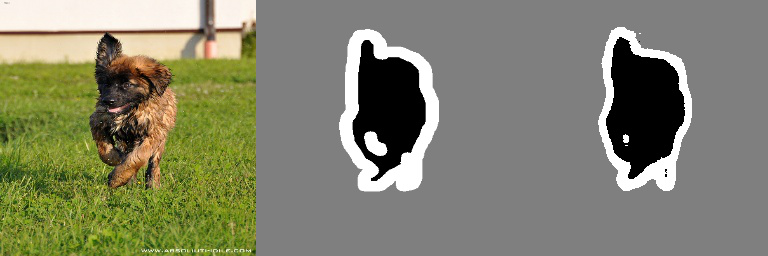

In [22]:
img = load_img("mosaic_1.jpg")
img

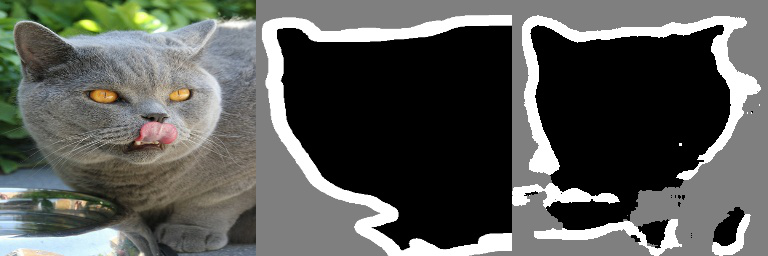

In [23]:
img = load_img("mosaic_2.jpg")
img

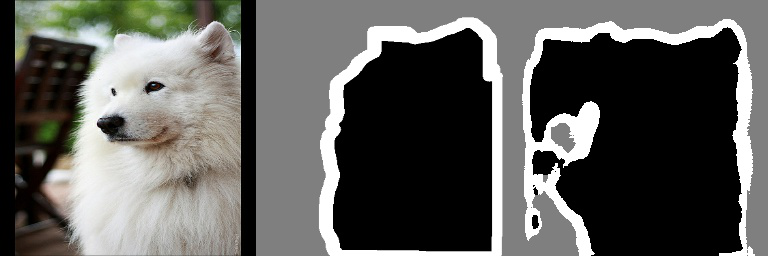

In [24]:
img = load_img("mosaic_3.jpg")
img

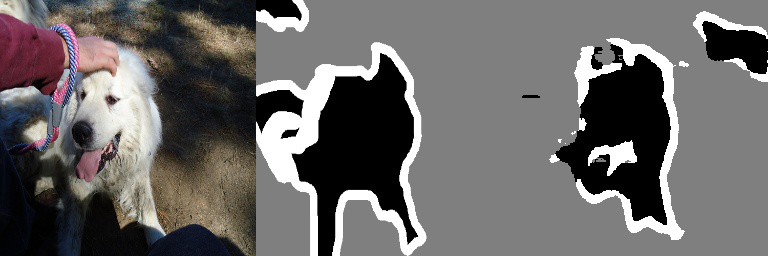

In [25]:
img = load_img("mosaic_4.jpg")
img

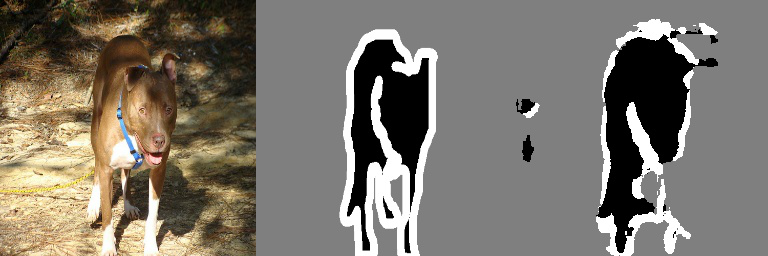

In [26]:
img = load_img("mosaic_5.jpg")
img

## Conclusions

In this recipe, we implemented and trained a U-Net from scratch to segment the body and contour of household pets. As we saw, the network did learn, but still offers room for improvement.

The ability to semantically segment the contents of an image is of paramount importance in several domains, such as in medicine, where what's more important than knowing if a condition, such as a malignant tumor, is present, is to determine the actual location, shape, and area of said ailment. The field of biomedicine is where U-Net made its debut. In 2015, it outperformed established methods for segmentation, such as sliding-windows convolutional networks, using far less data.

As we learned in this recipe, the key is in its end-to-end nature, where both the encoder and decoder are comprised of convolutions that form a contracting path, whose job is to capture context and a symmetric expanding path, thereby enabling precise localization.

Both of the aforementioned paths can be as deep as needed, depending on the nature of the dataset. This depth customization is viable due to the presence of skip connections, which allow the gradients to flow farther down the network, thus preventing the vanishing gradient problem (this is similar to what ResNet does).
